In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
import seaborn as sns
import tqdm
from rdkit import Chem

from utils import is_pattern, nitro_mol, quino_mol, sulfa_mol
from utils import (check_pains_brenk, deduplicate_on_tan_sim,
                   determine_optimal_clustering_number, evaluate_scores,
                   evaluate_similarities, extract_legends_and_plot,
                   filter_for_logp_less_than, filter_for_mw_bounds,
                   filter_for_nitrofuran, filter_for_rotatable_bonds,
                   filter_for_sulfonamide, get_closest_tanimoto_from_drug_set,
                   keep_valid_molecules)

/Users/jackie16201/Desktop/Spring_2023/ngonorrhoeae_abx_ml_discovery/src/utils.py:5: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from rdkit.Chem import MCS, Descriptors, PandasTools, AllChem
<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


# PK+37K model on 800k dataset

In [ ]:
# read in data
data_dir = "../out/predictions_from_models/pk_37k_model/800k/"
df = pd.read_csv(data_dir + "broad800K_melis_predictions_04_25_2022.csv")
print("total number of predictions: ", len(df))
meta = pd.read_csv("../data/library_info/PublicStructures.txt", sep="\t")
df = df.merge(meta, left_on="smiles", right_on="SMILES", how="left")
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.to_csv(data_dir + "clean_preds_05_02_2022.csv", index=False)
df

In [ ]:
# process_preds(df, smiles_col = 'smiles', hit_col = 'hit', path = data_dir)
df = evaluate_scores(df, hit_col="hit")
df = df[df["hit"] > 0.4]  # looks like a good score cut-off to start with
df = evaluate_similarities(
    df,
    smiles_col="smiles",
    path=data_dir,
    train_set_path="../data/data_prep_for_ml/data_prep_for_ml_pk_37k_screen/FULL_03_19_2022.csv",
)
df.to_csv(data_dir + "inh04_preds_with_tanimoto_analysis.csv", index=False)

In [ ]:
data_dir = "../out/predictions_from_models/pk_37k_model/800k/"

# easy validation set - high scores, lenient similarity filtering
df = pd.read_csv(data_dir + "inh04_preds_with_tanimoto_analysis.csv")
df = df[df["tanimoto similarity to closest abx"] < 0.9]
df = df[df["tanimoto similarity to closest train set"] < 0.9]
df = df[df["hit"] > 0.9]
print(len(df))

folder = data_dir + "easy_val_set_inh09_tanabx09_tantrainset09/"
os.mkdir(folder)
df, mols = extract_legends_and_plot(df, "easyval.png", folder, num_clusters=25)
df.to_csv(folder + "finalmols.csv", index=False)

In [ ]:
# medium validation set - moderate-to-high scores, stricter similarity filtering
df = pd.read_csv(data_dir + "inh04_preds_with_tanimoto_analysis.csv")
df = df[df["tanimoto similarity to closest abx"] < 0.5]
df = df[df["tanimoto similarity to closest train set"] < 0.5]
df = df[df["hit"] > 0.75]
print(len(df))

folder = data_dir + "medium_val_set_inh075_tanabx05_tantrainset05/"
os.mkdir(folder)
df, mols = extract_legends_and_plot(df, "mediumval.png", folder, num_clusters=60)
df.to_csv(folder + "finalmols.csv", index=False)

In [ ]:
# hard validation set - low-to-moderate scores, very strict similarity filtering
df = pd.read_csv(data_dir + "inh04_preds_with_tanimoto_analysis.csv")
df = df[df["tanimoto similarity to closest abx"] < 0.3]
df = df[df["tanimoto similarity to closest train set"] < 0.3]
df = df[df["hit"] > 0.4]
print(len(df))

folder = data_dir + "hard_val_set_inh04_tanabx03_tantrainset03/"
os.mkdir(folder)
df, mols = extract_legends_and_plot(df, "hardval.png", folder, num_clusters=25)
df.to_csv(folder + "finalmols.csv", index=False)

# PK+37K model on 5M commercially available dataset

In [ ]:
# read in data
data_dir = "../out/predictions_from_models/pk_37k_model/5M/"
df = pd.read_csv(data_dir + "extended_screen_set_melis_predictions_05_01_2022.csv")
df = df.reset_index(drop=True)
df.to_csv(data_dir + "clean_preds_05_02_2022.csv", index=False)

df = evaluate_scores(df, hit_col="hit")
df = df[df["hit"] > 0.7]  # looks like a good score cut-off to start with
df = evaluate_similarities(
    df,
    smiles_col="SMILES",
    path=data_dir,
    train_set_path="../data/data_prep_for_ml/data_prep_for_ml_pk_37k_screen/FULL_03_19_2022.csv",
    thresh_name="07",
)
df.to_csv(data_dir + "inh07_preds_with_tanimoto_analysis.csv", index=False)

In [ ]:
# read in data
data_dir = "../out/predictions_from_models/pk_37k_model/5M/"
df = pd.read_csv(data_dir + "inh07_preds_with_tanimoto_analysis.csv")
df = df[df["tanimoto similarity to closest abx"] < 0.5]
df = df[df["tanimoto similarity to closest train set"] < 0.9]
df = df.sort_values("hit", ascending=False)
df = df[df["hit"] < 0.9]  # only look at those < 0.9 for maximum novelty
df = df[df["hit"] > 0.85]  # only look at those >0.85 for now

# keep only valid frags
df, mols = keep_valid_molecules(df, "SMILES")

# keep only frags without pains or brenk
df, mols = check_pains_brenk(df, mols, method="pains", thresh=0)
df, mols = check_pains_brenk(df, mols, method="brenk", thresh=2)

# filter for rotatable bonds
df, mols = filter_for_rotatable_bonds(df, mols, "SMILES", 5)

# filter for nitrofurans
df, mols = filter_for_nitrofuran(df, mols)

# cluster
folder = data_dir + "extended_screen_set_analysis_cutoff0.85_allow_2_brenk/"
os.mkdir(folder)
df, mols = extract_legends_and_plot(
    df, "clust.png", folder, num_clusters=100, smiles_col="SMILES", name_col="Database"
)
df.to_csv(folder + "finalmols.csv", index=False)

In [ ]:
# read in data
data_dir = "../out/predictions_from_models/pk_37k_model/5M/"
df = pd.read_csv(data_dir + "inh07_preds_with_tanimoto_analysis.csv")
df = df[df["tanimoto similarity to closest abx"] < 0.5]
df = df[df["tanimoto similarity to closest train set"] < 0.5]
df = df.sort_values("hit", ascending=False)
df = df[df["hit"] > 0.9]  # only look at those > 0.9 for maximum novelty

# keep only valid frags
df, mols = keep_valid_molecules(df, "SMILES")

# keep only frags without pains or brenk
df, mols = check_pains_brenk(df, mols, method="pains", thresh=0)
df, mols = check_pains_brenk(df, mols, method="brenk", thresh=2)

# filter for rotatable bonds and logp
# df, mols = filter_for_rotatable_bonds(df, mols, 'SMILES', 5)
df, mols = filter_for_logp_less_than(df, mols, 3)

# cluster
folder = data_dir + "extended_screen_set_analysis_cutoff_molport_order_1/"
os.mkdir(folder)
df, mols = extract_legends_and_plot(
    df, "clust.png", folder, num_clusters=50, smiles_col="SMILES", name_col="Database"
)
df.to_csv(folder + "finalmols.csv", index=False)

# PK+37K+1st round val model on 5M commercially available dataset

In [ ]:
# read in data
data_dir = "../out/predictions_from_models/pk_37k_1round_model/5M/"
df = pd.read_csv(
    data_dir
    + "extended_screen_set_with_FINALbayHO11152022_melis_predictions_11_22_2022.csv"
)
print(len(df))
meta = pd.read_csv("../data/library_info/PublicStructures.txt", sep="\t")
df = df.merge(meta, left_on="SMILES", right_on="SMILES", how="left")
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.to_csv(data_dir + "clean_preds_11_22_2022.csv", index=False)

df = evaluate_scores(df, hit_col="hit")
df = df[df["hit"] > 0.5]  # looks like a good score cut-off to start with
df = evaluate_similarities(
    df,
    smiles_col="SMILES",
    path=data_dir,
    train_set_path="../data/data_prep_for_ml/data_prep_for_ml_pk_37k_first_round_val_screen/FULL_10_26_2022.csv",
    thresh_name="05",
    hit_col="hit",
    just_hits=True,
)
df.to_csv(data_dir + "inh05_preds_with_tanimoto_analysis.csv", index=False)

In [ ]:
# read in data
data_dir = "../out/predictions_from_models/pk_37k_1round_model/5M/"
df = pd.read_csv(data_dir + "inh05_preds_with_tanimoto_analysis.csv")
df = df[df["tanimoto similarity to closest abx"] < 0.5]
df = df[df["tanimoto similarity to closest train set"] < 0.5]
df = df.sort_values("hit", ascending=False)

print("length of all preds: ", len(df))

# keep only valid frags
df, mols = keep_valid_molecules(df, "SMILES")

# keep only frags without pains or brenk
df, mols = check_pains_brenk(df, mols, method="pains", thresh=0)
df, mols = check_pains_brenk(df, mols, method="brenk", thresh=1)

# filter for nitrofurans
df, mols = filter_for_nitrofuran(df, mols)

# filter for sulfonamides
df, mols = filter_for_sulfonamide(df, mols)

# filter for logP
df, mols = filter_for_logp_less_than(df, mols, 5)
df, mols = filter_for_mw_bounds(df, mols, lower_bound=200, upper_bound=100000000)

# deduplicate based on tanimoto similarity
df = deduplicate_on_tan_sim(df, mols)
df.to_csv(data_dir + "mols_filtered_aggressively_12092022.csv", index=False)

In [ ]:
# determine appropriate number of clusters
df, min_sims = determine_optimal_clustering_number(
    df, max_num_clusters=len(df), smiles_col="SMILES"
)
min_sim_df = pd.DataFrame()
min_sim_df["clusters"] = list(range(1, len(df)))
min_sim_df["min_sim_within_cluster"] = min_sims
min_sim_df = min_sim_df[min_sim_df["min_sim_within_cluster"] > 0.25]
min_sim_df

In [ ]:
# plot final number of clusters
folder = data_dir + "newfilters12092022/"
os.mkdir(folder)
df, mols = extract_legends_and_plot(
    df, "grp.png", folder, num_clusters=244, smiles_col="SMILES", name_col="Database"
)
df.to_csv(folder + "finalmols.csv", index=False)

# pick highest scoring mols from each cluster
finaldf = pd.DataFrame()
for clust, smalldf in df.groupby("cluster"):
    smalldf = smalldf.sort_values("hit", ascending=False)
    smalldf = pd.DataFrame(smalldf.iloc[0, :]).T
    finaldf = pd.concat([finaldf, smalldf])
finaldf.to_csv(folder + "finalmols_best_from_each_cluster.csv", index=False)
finaldf

# PK+37K+3 rounds val model on Enamine REAL Diversity (43.7M) dataset

In [ ]:
# read in data
data_dir = (
    "../out/predictions_from_models/pk_37k_3roundsval_model/enamine_REAL_diversity/"
)
df = pd.read_csv(
    data_dir
    + "melis_enamine_REAL_diversity_full_43M_with_bayHOv303312023_06_12_2023.csv"
)
df = df.drop_duplicates(subset="idnumber")
df = df.reset_index(drop=True)

df = evaluate_scores(df, hit_col="hit")
df = df[df["hit"] > 0.5]  # looks like a good score cut-off to start with
df = evaluate_similarities(
    df,
    smiles_col="smiles",
    path=data_dir,
    train_set_path="../data/data_prep_for_ml/data_prep_for_ml_pk_37k_three_rounds_val/FULL_03_31_2023.csv",
    thresh_name="05",
    hit_col="hit",
    just_hits=True,
)
df.to_csv(data_dir + "inh05_preds_with_tanimoto_analysis.csv", index=False)

In [ ]:
# grab just highest-scoring compounds
df = df[df["hit"] > 0.7]

# cluster
folder = data_dir + "enamine_real_diversity_analysis_cutoff0.7/"
os.mkdir(folder)
df, mols = extract_legends_and_plot(
    df, "clust.png", folder, num_clusters=20, smiles_col="smiles", name_col="idnumber"
)
df.to_csv(folder + "finalmols.csv", index=False)

In [ ]:
# Melis also wanted to see compounds with PS >0.5 and TS_Abx < 0.5
data_dir = (
    "../out/predictions_from_models/pk_37k_3roundsval_model/enamine_REAL_diversity/"
)
df = pd.read_csv(data_dir + "inh05_preds_with_tanimoto_analysis.csv")
# already all >0.5 score
df = df[df["tanimoto similarity to closest abx"] < 0.5]
df = df[df["tanimoto similarity to closest train set"] < 0.9]
df = df.sort_values("hit", ascending=False)
print("length of all preds: ", len(df))
df.to_csv(
    data_dir
    + "enamine_real_diversity_analysis_cutoff0.5_tanabx0.5_tantrainset_0.9.csv",
    index=False,
)
df

# Evaluate scores of predictions relative to their similarity to training set

In [2]:
data_dir = "../out/predictions_from_models/pk_37k_model/800k/"
df = pd.read_csv(data_dir + "clean_preds_05_02_2022.csv")
print("total number of predictions: ", len(df))

# Bin the hit scores into intervals of 0.1
df["hit_bin"] = pd.cut(
    df["hit"], bins=np.arange(0, 1.1, 0.1), right=False, include_lowest=True
)

# Sample 100 points from each hit_bin
df_sampled = (
    df.groupby("hit_bin")
    .apply(lambda x: x.sample(n=100, random_state=42, replace=False))
    .reset_index(drop=True)
)
df_sampled

total number of predictions:  799147


,smiles,hit,hit_epi_unc,Name,PROJECT_CODE,PROJECT_NAME,CXSMILES,STEREO_COMMENTS,SMILES,hit_bin
0,FC(F)(F)C(=O)NNc1cccc(n1)Cl,0.007657,7.730373e-04,BRD-K78861772,2001,General HTS Sets,FC(F)(F)C(=O)NNc1cccc(Cl)n1,as drawn,FC(F)(F)C(=O)NNc1cccc(n1)Cl,"[0.0, 0.1)"
1,Fc1ccc(cc1)[C@@H](CNC(=O)CCNC(=O)c1ccccc1Cl)N1...,0.028942,5.721387e-04,BRD-A27180129,2001,General HTS Sets,Fc1ccc(cc1)[C@@H](CNC(=O)CCNC(=O)c1ccccc1Cl)N1...,as drawn,Fc1ccc(cc1)[C@@H](CNC(=O)CCNC(=O)c1ccccc1Cl)N1...,"[0.0, 0.1)"
2,Fc1ccccc1-n1nnnc1SCC(=O)N1c2ccccc2Sc2ccc(cc21)Cl,0.092305,5.380618e-03,BRD-K32314492,2001,General HTS Sets,Fc1ccccc1-n1nnnc1SCC(=O)N1c2ccccc2Sc2ccc(Cl)cc12,as drawn,Fc1ccccc1-n1nnnc1SCC(=O)N1c2ccccc2Sc2ccc(cc21)Cl,"[0.0, 0.1)"
3,CCOc1cccc(c1OCC)CC(=O)N1CCc2c([nH]c3ccccc23)[C...,0.078443,2.423981e-03,BRD-A47181268,2001,General HTS Sets,CCOc1cccc(CC(=O)N2CCc3c([nH]c4ccccc34)[C@@H]2c...,as drawn,CCOc1cccc(c1OCC)CC(=O)N1CCc2c([nH]c3ccccc23)[C...,"[0.0, 0.1)"
4,CS(=O)(=O)N1CCC(CC1)CNC(=O)CSC1CCCC1,0.000571,2.536617e-06,BRD-K00014870,5001,CMAP,CS(=O)(=O)N1CCC(CNC(=O)CSC2CCCC2)CC1,as drawn,CS(=O)(=O)N1CCC(CC1)CNC(=O)CSC1CCCC1,"[0.0, 0.1)"
...,...,...,...,...,...,...,...,...,...,...
995,COCc1nc(ncc1C(=O)O)N1CCN(CC1)c1ccccc1F,0.945348,1.051740e-02,BRD-K80594128,7159,Calico PRISM,COCc1nc(ncc1C(O)=O)N1CCN(CC1)c1ccccc1F,as drawn,COCc1nc(ncc1C(=O)O)N1CCN(CC1)c1ccccc1F,"[0.9, 1.0)"
996,CO[C@H]1/C=C\O[C@@]2(C)Oc3c(c(c4c(c(c5c(nc6cc(...,0.931226,8.952260e-03,BRD-K53484294,7161,Repurposing,CO[C@H]1\C=C\O[C@@]2(C)Oc3c(C2=O)c2c4nc5cc(C)c...,as drawn,CO[C@H]1/C=C\O[C@@]2(C)Oc3c(c(c4c(c(c5c(nc6cc(...,"[0.9, 1.0)"
997,C[C@H]1CC/C=C\[C@H]2O[C@]34C=CCN(Cn5nnc6ccccc5...,0.928135,8.986644e-03,BRD-A96326688,2001,General HTS Sets,C[C@H]1CC\C=C/[C@H]2O[C@@]34C=CCN(Cn5nnc6ccccc...,as drawn,C[C@H]1CC/C=C\[C@H]2O[C@]34C=CCN(Cn5nnc6ccccc5...,"[0.9, 1.0)"
998,CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1OC(=O)C)O[C@H...,0.973087,8.922754e-03,BRD-A24297246,2001,General HTS Sets,CO[C@H]1C[C@H](O[C@H]2[C@H](C)[C@@H](O[C@H]3O[...,as drawn,CO[C@H]1C[C@@H](O[C@@H](C)[C@@H]1OC(=O)C)O[C@H...,"[0.9, 1.0)"


In [3]:
train_set = pd.read_csv(
    "../data/data_prep_for_ml/data_prep_for_ml_pk_37k_screen/FULL_03_19_2022.csv"
)
train_set = train_set[train_set["hit"] == 1.0]
train_set

,Name,SMILES,hit
0,BRD-K93123848,Cn1c(nc2cc(ccc12)Oc1ccnc(c1)-c1ncc([nH]1)C(F)(...,1.0
1,BRD-K30309936,C[C@H]1CCCCO[C@H](CN(C)Cc2ccc(cc2)C(F)(F)F)[C@...,1.0
2,TRIMETHADIONE,CN1C(=O)OC(C)(C)C1=O,1.0
3,BRD-K76424103,C[C@]1([C@@H](N(Cc2ccccc2)C(=O)c2ccccc21)c1ccc...,1.0
4,BRD-K65130196,CC(C)(C)NCCCCOc1ccc(cc1C(C)(C)C)Cl,1.0
...,...,...,...
31214,BRD-K51899933,CCCCc1nc(cn1-c1ccc(cc1)Oc1ccc(cc1)Cl)-c1ccc(cc...,1.0
31215,BRD-K01825574,CON=C(C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(=O)O)C...,1.0
31216,BRD-K90151896,CC(C)N1CC[C@H](CNCc2ccc(cc2)Oc2ccccc2)Oc2c(ccc...,1.0
31217,BRD-K49063828,CCO[C@H]1OC(=C[C@H]([C@@H]1CCCO)c1ccc2c(c1)OCO...,1.0


In [4]:
train_mols = [Chem.MolFromSmiles(smi) for smi in list(train_set["SMILES"])]
train_fps = [
    Chem.RDKFingerprint(mol) if mol is not None else None
    for mol in tqdm.tqdm(train_mols)
]
df_sampled["similarity"] = get_closest_tanimoto_from_drug_set(
    list(df_sampled["smiles"]), train_fps
)

100%|██████████| 1269/1269 [00:03<00:00, 414.85it/s]


/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/jackie16201/opt/anaconda3/envs/chemprop010821/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


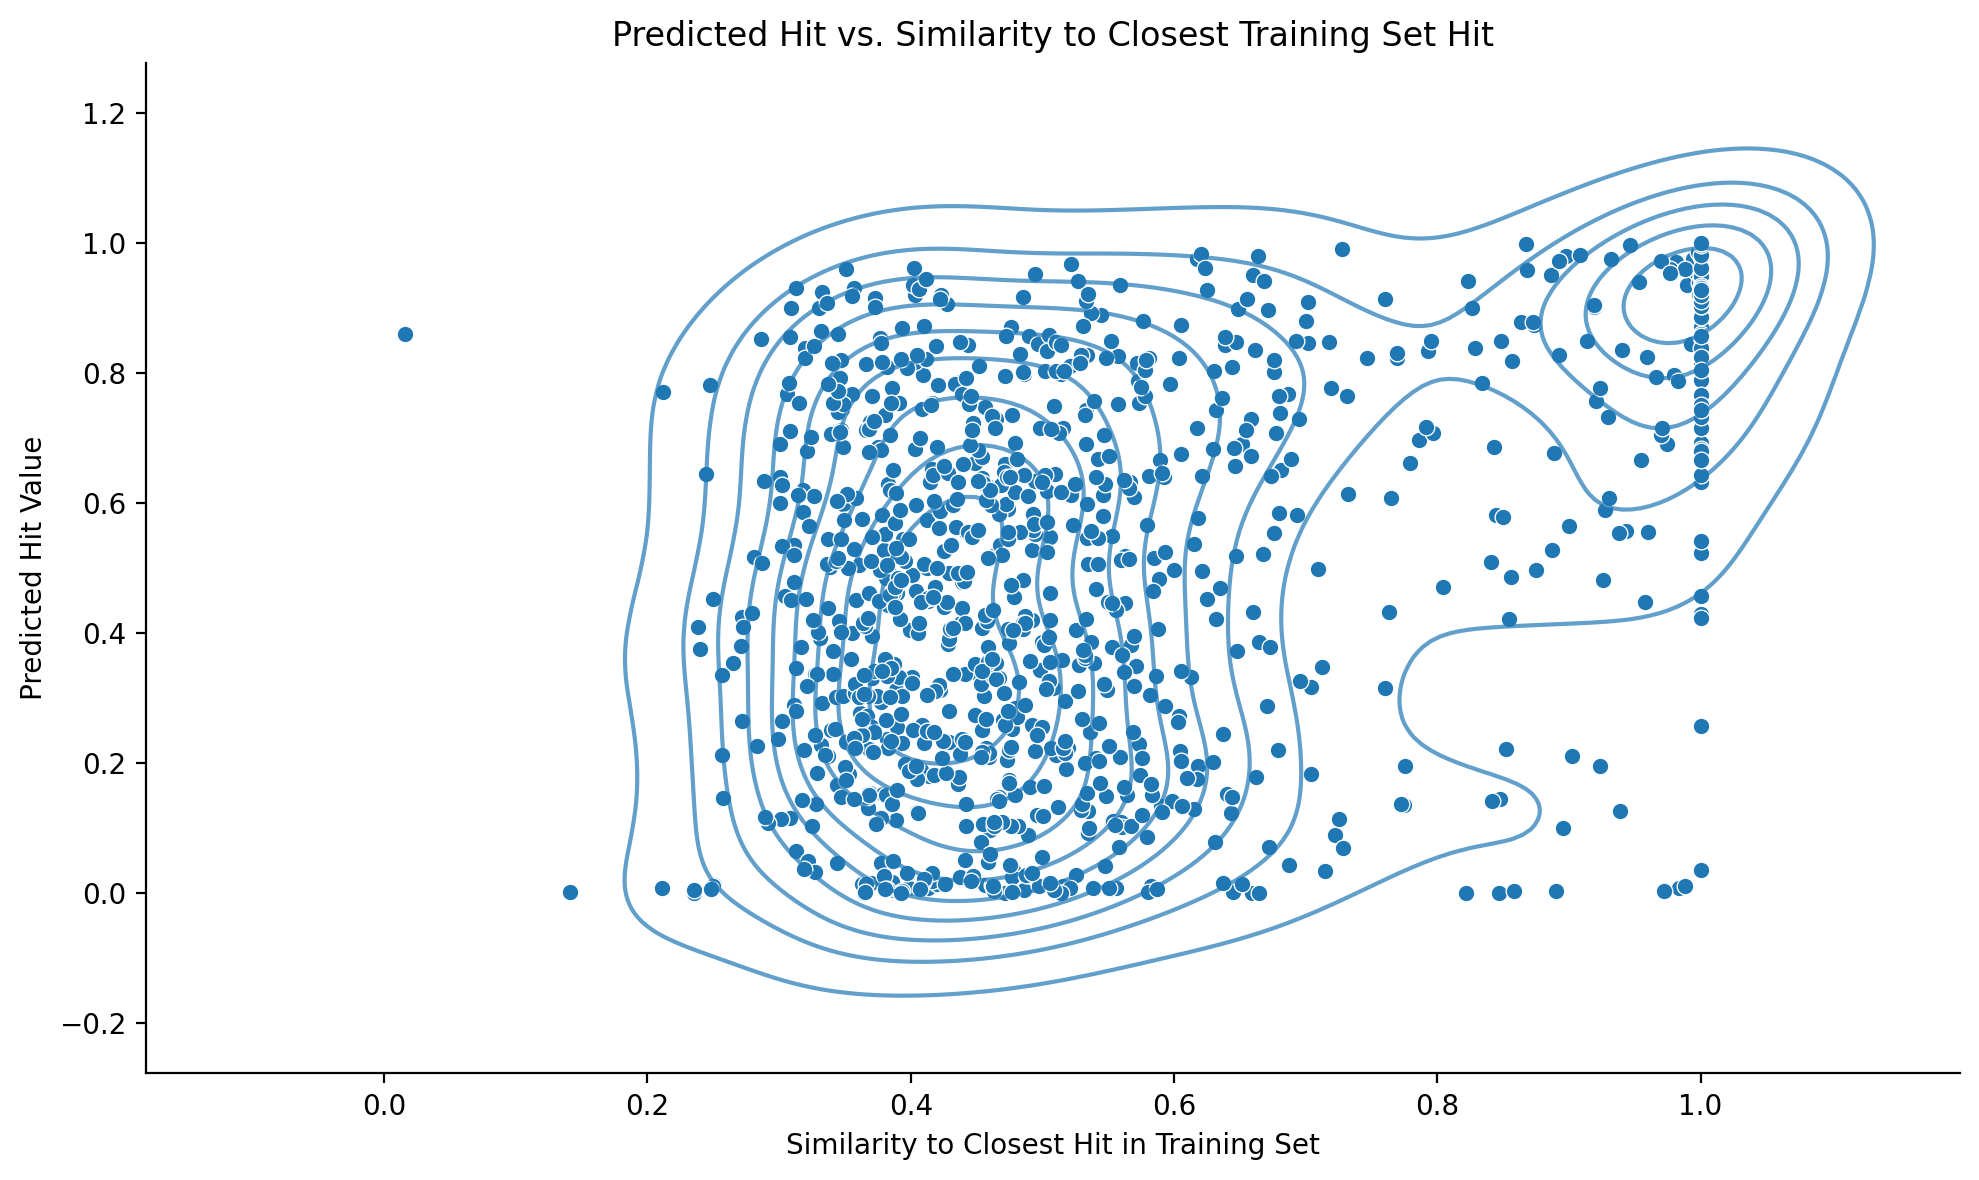

(0.3684339268704312, 1.651405933483249e-33)


In [7]:
# Plotting the scatter plot
plt.figure(figsize=(10, 6), dpi=200)
sns.scatterplot(df_sampled["similarity"], df_sampled["hit"])
sns.kdeplot(df_sampled["similarity"], df_sampled["hit"], alpha=0.7)
plt.xlabel("Similarity to Closest Hit in Training Set")
plt.ylabel("Predicted Hit Value")
plt.title("Predicted Hit vs. Similarity to Closest Training Set Hit")
sns.despine()
plt.tight_layout()
plt.savefig("../figure_panels/addtnl_questions/tan_sim_train_set_hit_scatter.svg")
plt.show()

print(sp.pearsonr(df_sampled["similarity"], df_sampled["hit"]))

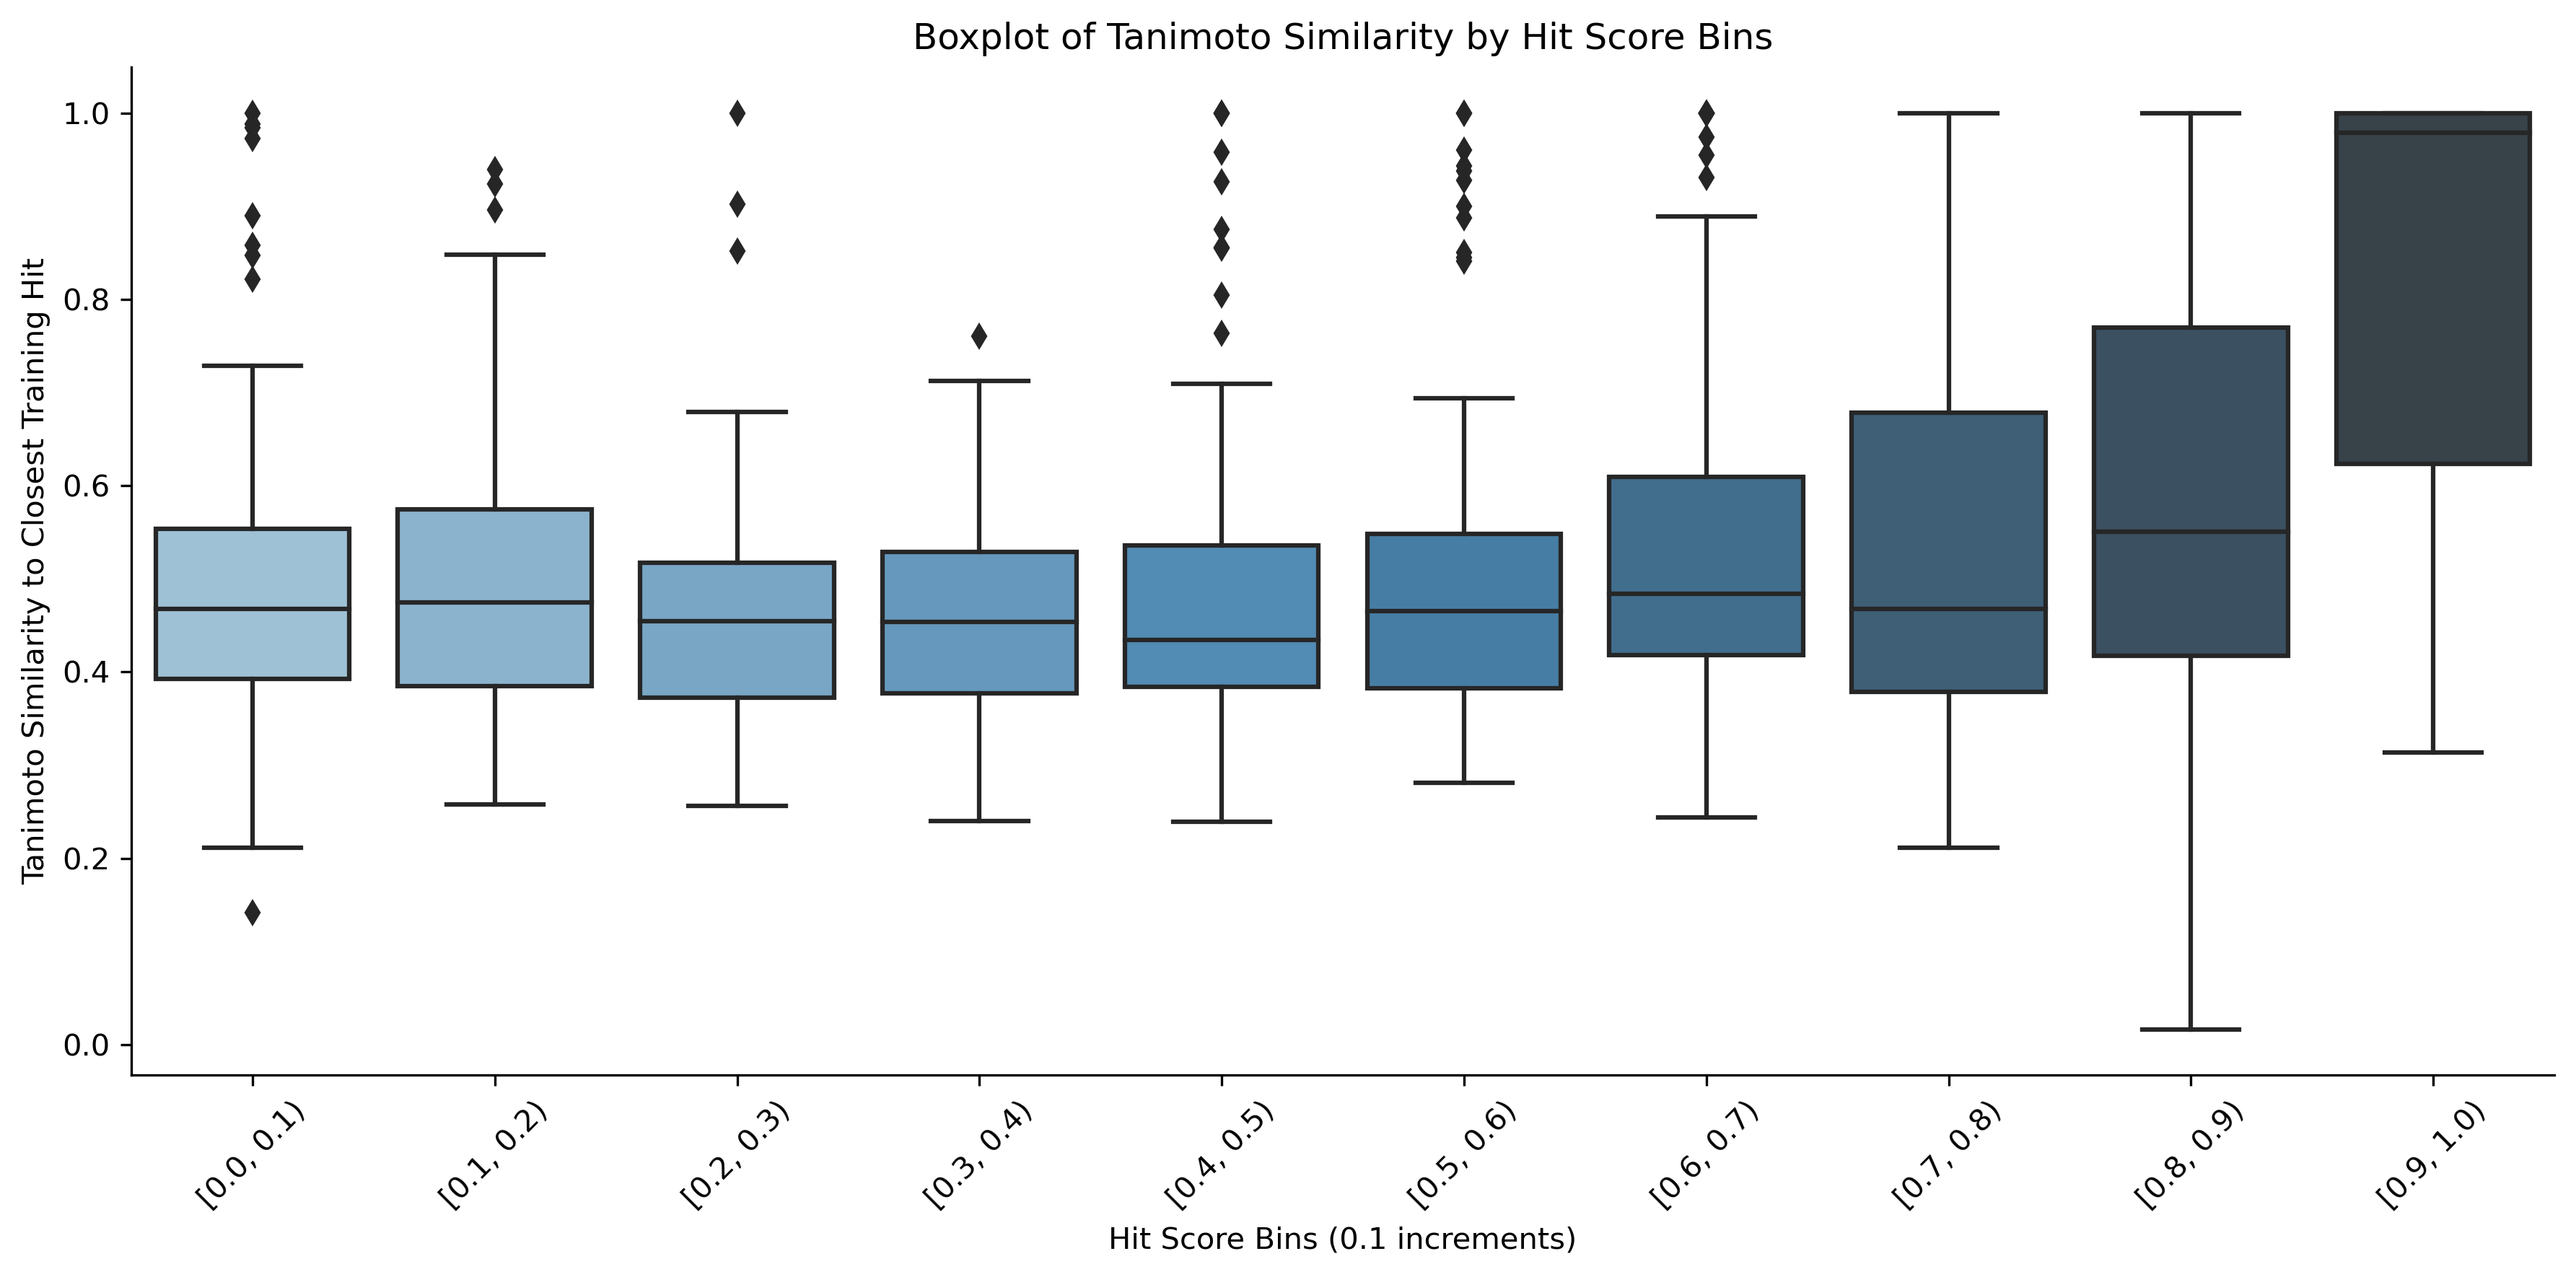

In [8]:
# Create the boxplot
plt.figure(figsize=(12, 6), dpi=300)
sns.boxplot(
    data=df_sampled,
    x="hit_bin",
    y="similarity",
    palette=sns.color_palette(palette="Blues_d", n_colors=10),
)
# sns.swarmplot(data=df_sampled, x='hit_bin', y='similarity', palette=sns.color_palette(palette='Blues_d'))
plt.xlabel("Hit Score Bins (0.1 increments)")
plt.ylabel("Tanimoto Similarity to Closest Training Hit")
plt.title("Boxplot of Tanimoto Similarity by Hit Score Bins")
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.savefig("../figure_panels/addtnl_questions/tan_sim_train_set_hit_box.svg")
plt.show()

In [ ]:
# get hit scores of molecules with nitrofurans, sulfonamides, quinolones
df = pd.read_csv(data_dir + "clean_preds_05_02_2022.csv")
df = df.sample(frac=0.05, random_state=42)
df_mols = [Chem.MolFromSmiles(smi) for smi in tqdm.tqdm(df["smiles"])]

# get sulfonamides
keep_indices = [is_pattern(mol, sulfa_mol) for mol in df_mols]
df_sulfa = df[keep_indices]
print("length of df with sulfonamides: ", len(df_sulfa))
sulfa_mols = [m for i, m in enumerate(df_mols) if keep_indices[i]]

# get nitrofurans
keep_indices = [is_pattern(mol, nitro_mol) for mol in df_mols]
df_nitro = df[keep_indices]
print("length of df with nitrofurans: ", len(df_nitro))
nitro_mols = [m for i, m in enumerate(df_mols) if keep_indices[i]]

# get quinolones
keep_indices = [is_pattern(mol, quino_mol) for mol in df_mols]
df_quino = df[keep_indices]
print("length of df with quinolones: ", len(df_quino))
quino_mols = [m for i, m in enumerate(df_mols) if keep_indices[i]]

100%|██████████| 39957/39957 [00:08<00:00, 4987.87it/s]
/Users/jackie16201/Desktop/Spring_2023/ngonorrhoeae_abx_ml_discovery/src/utils.py:56: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs = MCS.FindMCS([mol, pattern_mol], atomCompare='elements',completeRingsOnly = True)


length of df with sulfonamides:  5875
length of df with nitrofurans:  23
length of df with quinolones:  113


/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_69503/354470419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sulfa['group'] = 'sulfonamides'
/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_69503/354470419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nitro['group'] = 'nitrofurans'
/var/folders/py/8hwb28r933z4xh4q0dw5hz2h0000gn/T/ipykernel_69503/354470419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

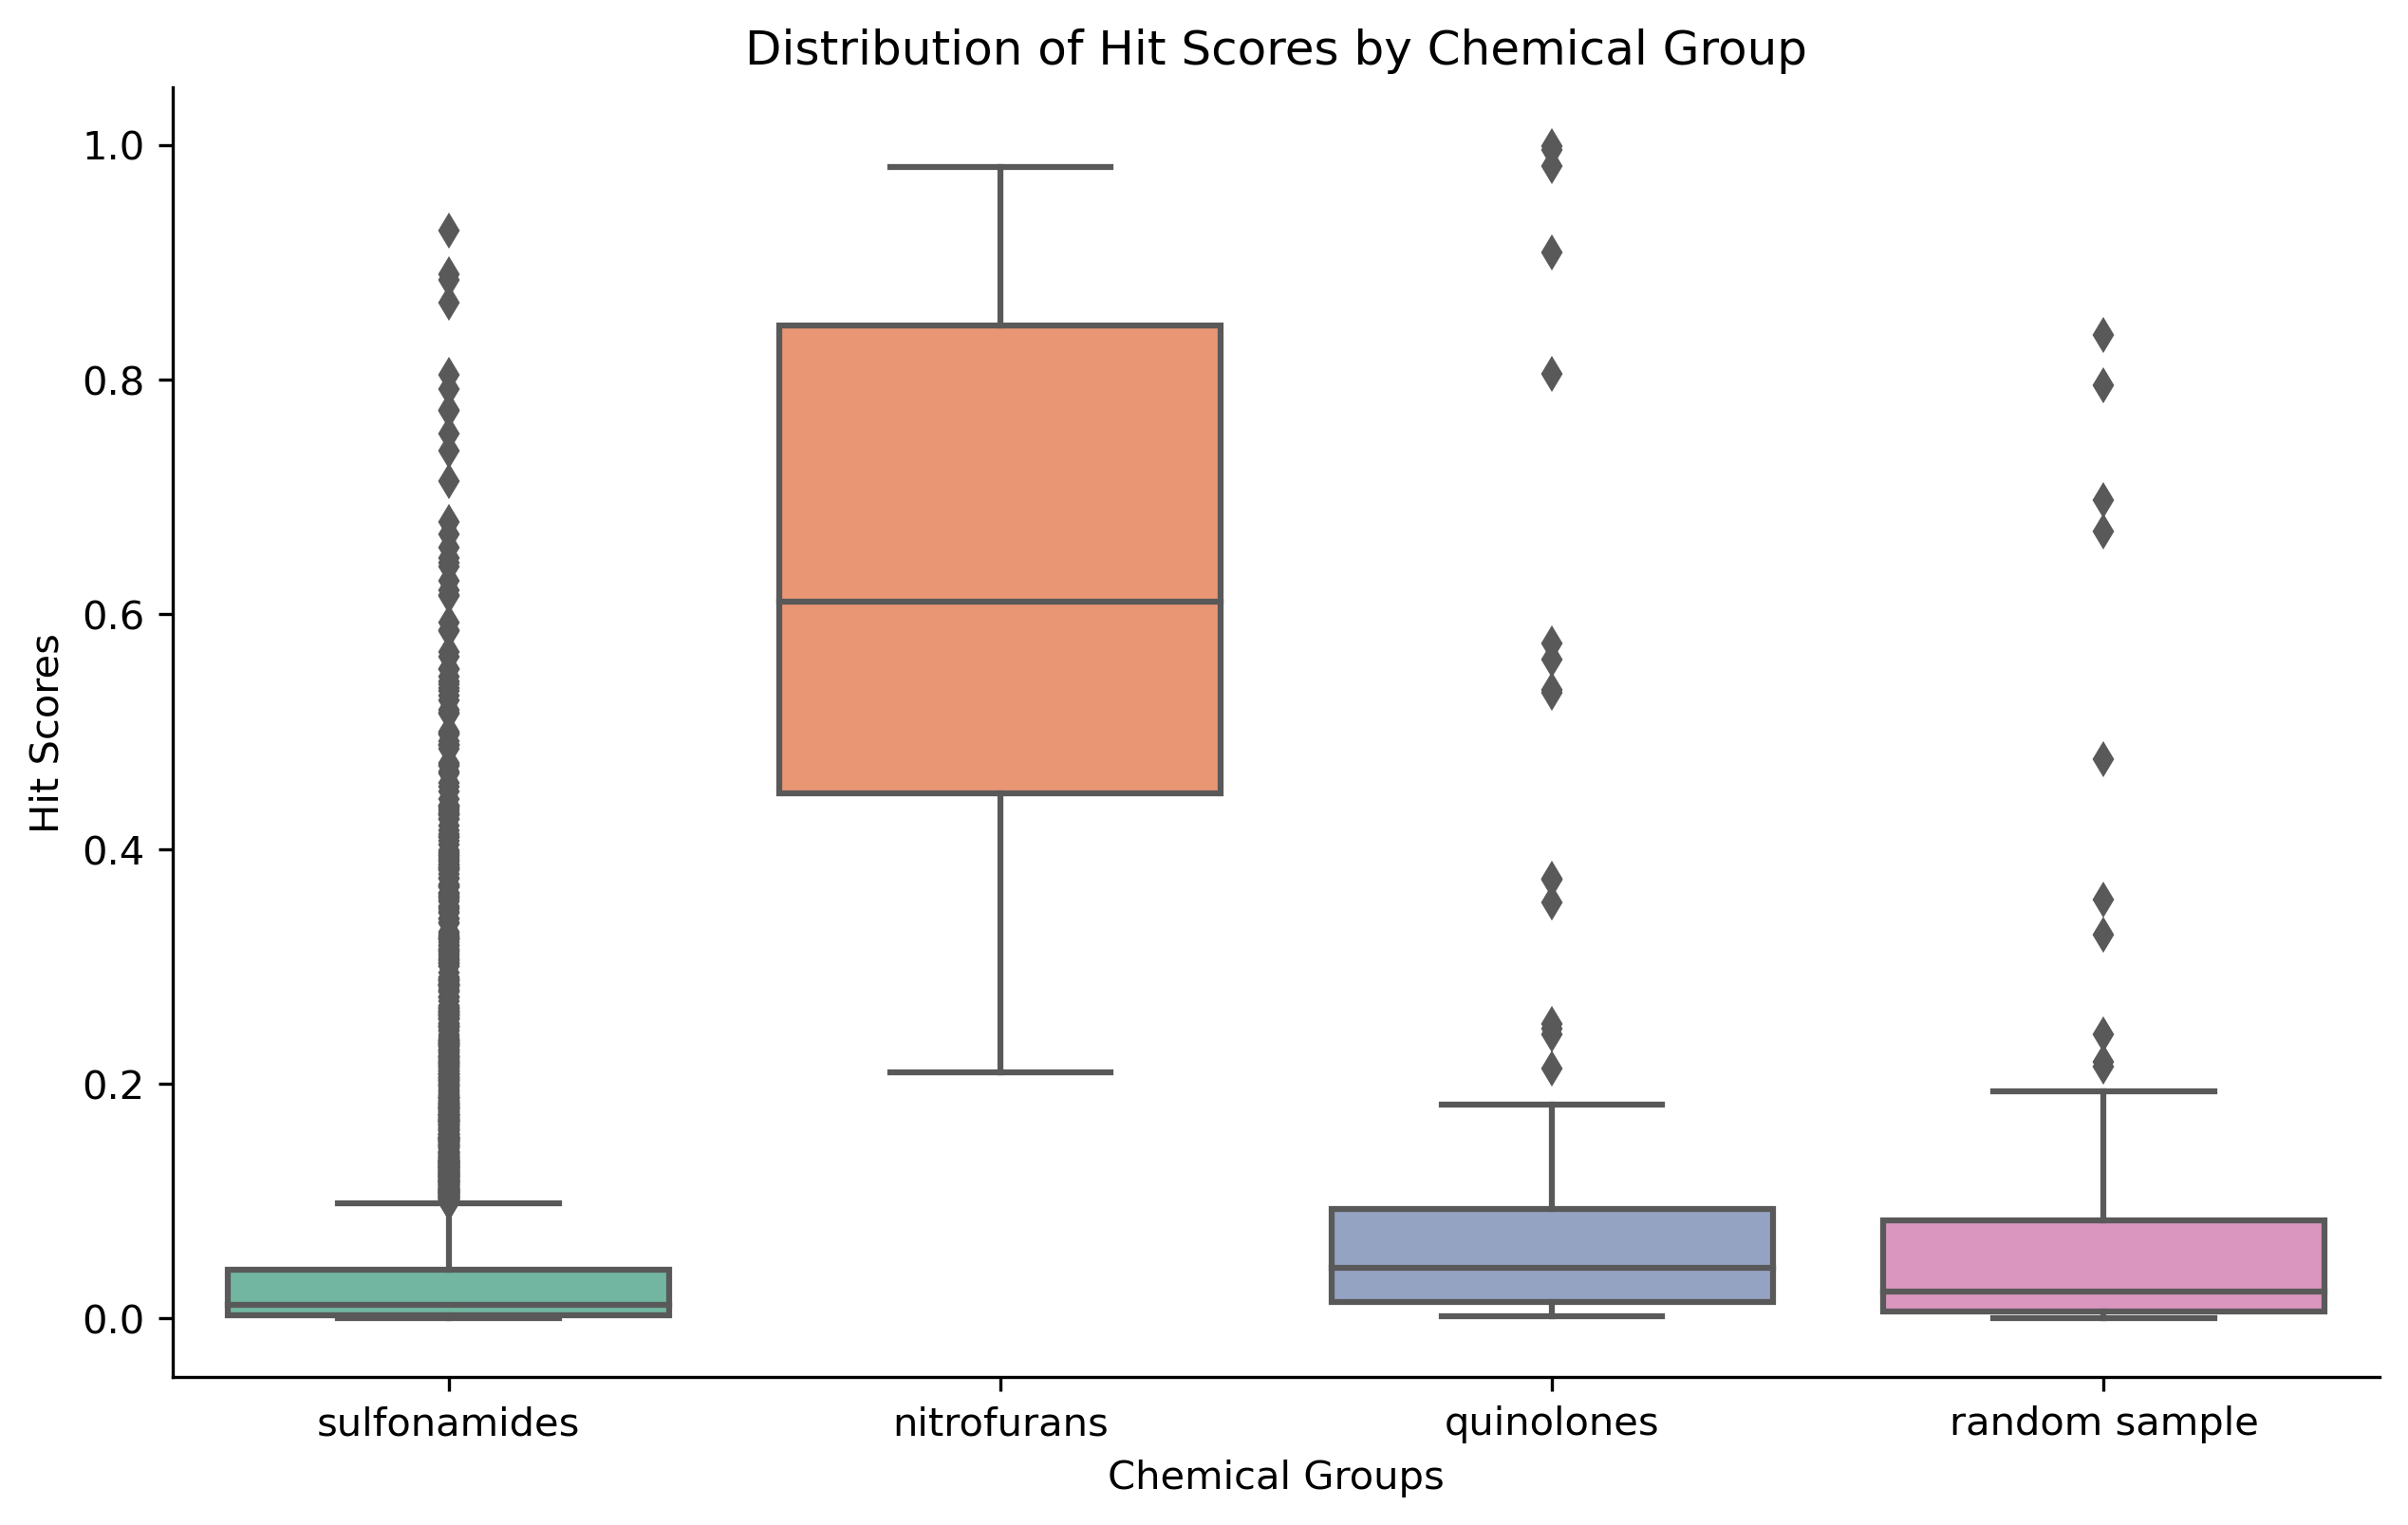

In [32]:
df_sulfa["group"] = "sulfonamides"
df_nitro["group"] = "nitrofurans"
df_quino["group"] = "quinolones"

# Create a random sample group of similar size as the sulfonamides group
random_sample = df.sample(n=len(df_quino), random_state=42)
random_sample["group"] = "random sample"

# Combine all groups into a single DataFrame
df_boxplot = pd.concat([df_sulfa, df_nitro, df_quino, random_sample], ignore_index=True)

# Plot
plt.figure(figsize=(10, 6), dpi=300)
sns.boxplot(data=df_boxplot, x="group", y="hit", palette="Set2")
plt.xlabel("Chemical Groups")
plt.ylabel("Hit Scores")
plt.title("Distribution of Hit Scores by Chemical Group")
sns.despine()
plt.savefig("../figure_panels/addtnl_questions/known_scaffolds_hit_score.svg")
plt.show()